Environment ready. PyTorch device: cpu
Using Colab cache for faster access to the 'creditcardfraud' dataset.
Dataset downloaded to: /kaggle/input/creditcardfraud
Scaler saved as scaler_creditcard.joblib
Training samples: torch.Size([454902, 29]) Test samples: torch.Size([56962, 29])
Epoch 1/10, Train Loss: 0.1287, Val Loss: 0.0551
Epoch 2/10, Train Loss: 0.0337, Val Loss: 0.0458
Epoch 3/10, Train Loss: 0.0220, Val Loss: 0.0395
Epoch 4/10, Train Loss: 0.0166, Val Loss: 0.0361
Epoch 5/10, Train Loss: 0.0136, Val Loss: 0.0350
Epoch 6/10, Train Loss: 0.0120, Val Loss: 0.0314
Epoch 7/10, Train Loss: 0.0106, Val Loss: 0.0318
Epoch 8/10, Train Loss: 0.0095, Val Loss: 0.0289
Epoch 9/10, Train Loss: 0.0083, Val Loss: 0.0281
Epoch 10/10, Train Loss: 0.0073, Val Loss: 0.0291


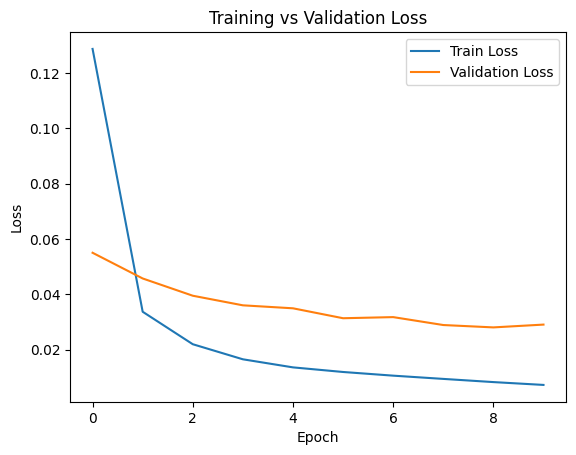

Optimal threshold: 0.99853766
Precision at threshold: 0.8041237113402062
Recall at threshold: 0.7959183673469388
              precision    recall  f1-score   support

           0     0.9996    0.9997    0.9997     56864
           1     0.8041    0.7959    0.8000        98

    accuracy                         0.9993     56962
   macro avg     0.9019    0.8978    0.8998     56962
weighted avg     0.9993    0.9993    0.9993     56962

ROC-AUC: 0.9735331632653061


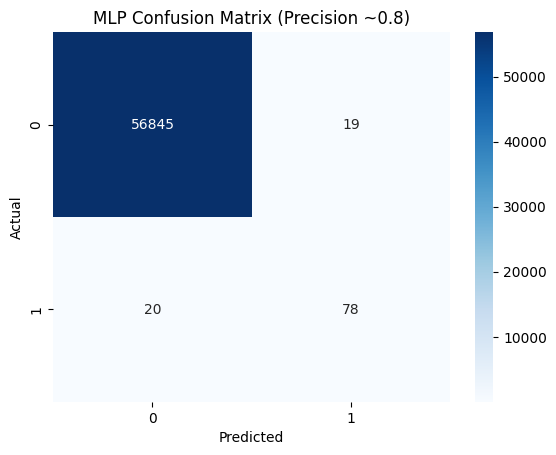

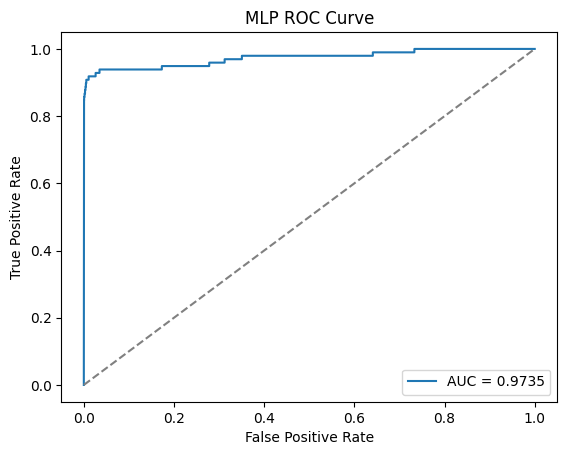

Saved model, scaler, and optimal threshold for deployment.


In [2]:
# ============================================
# Cell 1: Imports and environment setup
# ============================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, confusion_matrix, auc
)
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Environment ready. PyTorch device:", device)


# ============================================
# Cell 2: Helper plotting and metrics functions
# ============================================
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_roc(y_true, y_scores, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.4f}")
    plt.plot([0,1],[0,1],'--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

def classification_metrics(y_true, y_pred, y_scores=None):
    print(classification_report(y_true, y_pred, digits=4))
    if y_scores is not None:
        print("ROC-AUC:", roc_auc_score(y_true, y_scores))


# ============================================
# Cell 3: Load dataset via KaggleHub
# ============================================
import kagglehub
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Dataset downloaded to:", path)

df = pd.read_csv(os.path.join(path, "creditcard.csv"))


# ============================================
# Cell 4: Preprocessing
# ============================================
df["Amount_log"] = np.log1p(df["Amount"])
df_model = df.drop(["Time", "Amount", "Hour"], axis=1, errors="ignore")

X = df_model.drop("Class", axis=1)
y = df_model["Class"]

# Scale features and save scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler_creditcard.joblib")
print("Scaler saved as scaler_creditcard.joblib")

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

# SMOTE oversampling
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_sm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_sm.values, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False)

print("Training samples:", X_train_tensor.shape, "Test samples:", X_test_tensor.shape)


# ============================================
# Cell 5: Fully-Connected Neural Network (MLP)
# ============================================
class FraudMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

num_features = X_train_tensor.shape[1]
classifier = FraudMLP(num_features).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)


# ============================================
# Cell 6: Training (Overfitting detection)
# ============================================
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    classifier.train()
    epoch_train_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = classifier(xb).squeeze()
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    # Validation
    classifier.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = classifier(xb).squeeze()
            loss = criterion(pred, yb)
            epoch_val_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))
    val_losses.append(epoch_val_loss / len(val_loader))

    print(
        f"Epoch {epoch+1}/{num_epochs}, "
        f"Train Loss: {train_losses[-1]:.4f}, "
        f"Val Loss: {val_losses[-1]:.4f}"
    )

# Plot losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ============================================
# Cell 7: Evaluation and saving threshold
# ============================================
classifier.eval()
with torch.no_grad():
    y_probs = classifier(X_test_tensor.to(device)).squeeze().cpu().numpy()

desired_precision = 0.80
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_probs)

mask = precision_vals[:-1] >= desired_precision
idx = np.argmax(mask) if mask.any() else np.argmax(precision_vals[:-1])
optimal_threshold = thresholds[idx]

print("Optimal threshold:", optimal_threshold)
print("Precision at threshold:", precision_vals[idx])
print("Recall at threshold:", recall_vals[idx])

y_pred = (y_probs >= optimal_threshold).astype(int)

classification_metrics(y_test, y_pred, y_probs)
plot_confusion_matrix(y_test, y_pred, f"MLP Confusion Matrix (Precision ~{desired_precision})")
plot_roc(y_test, y_probs, "MLP ROC Curve")

# Save model, scaler, and threshold
torch.save(classifier.state_dict(), "mlp_fraud_model.pth")
joblib.dump(scaler, "scaler_creditcard.joblib")
joblib.dump(optimal_threshold, "mlp_threshold.pkl")
print("Saved model, scaler, and optimal threshold for deployment.")


Using Colab cache for faster access to the 'credit-card-fraud-detection-dataset-2023' dataset.
Path to dataset files: /kaggle/input/credit-card-fraud-detection-dataset-2023
   id        V1        V2        V3        V4        V5        V6        V7  \
0   0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1   1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2   2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3   3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4   4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0 -0.130006  0.727159  ... -0.110552  0.217606 -0.134794  0.165959  0.126280   
1 -0.133118  0.347452  ... -0.194936 -0.605761  0.079469 -0.577395  0.190090   
2 -0.095576 -0.261297  ... -0.005020  0.702906  0.945045 -1.154666 -0.605564   
3 -0.065130 -0.205698  ... -0.14

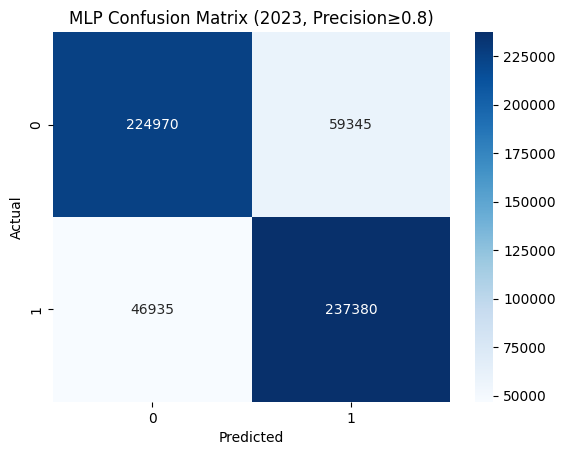

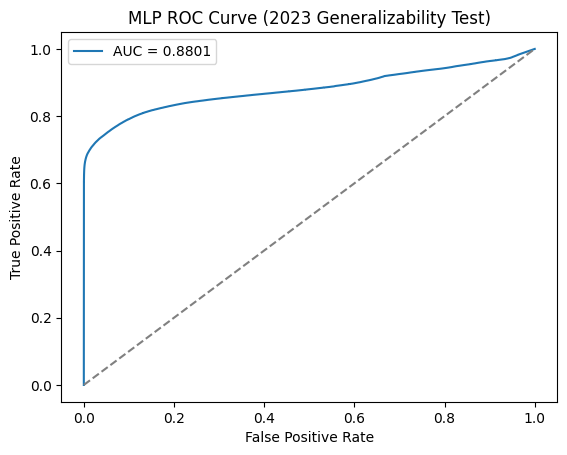

In [11]:
# ============================================
# Cell XX: Generalizability Testing (2023 dataset) for Deep Learning MLP
# ============================================

import pandas as pd
import numpy as np
import torch
import kagglehub
import os
import joblib
from sklearn.metrics import precision_recall_curve

# -----------------------------
# Ensure device is defined
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Load 2023 dataset
# -----------------------------
path_2023 = kagglehub.dataset_download(
    "nelgiriyewithana/credit-card-fraud-detection-dataset-2023"
)
print("Path to dataset files:", path_2023)

# KaggleHub sometimes places files inside folder structure
csv_files = []
for root, dirs, files in os.walk(path_2023):
    for f in files:
        if f.endswith(".csv"):
            csv_files.append(os.path.join(root, f))

if len(csv_files) == 0:
    raise FileNotFoundError("No CSV file found in 2023 dataset!")

csv_2023_path = csv_files[0]
df_2023 = pd.read_csv(csv_2023_path)
print(df_2023.head())

# -----------------------------
# Feature Engineering
# -----------------------------
df_2023["Amount_log"] = np.log1p(df_2023["Amount"])

X_2023 = df_2023.drop(["id", "Amount", "Class"], axis=1)
y_2023 = df_2023["Class"].values

# -----------------------------
# Load original scaler
# -----------------------------
if not os.path.exists("scaler_creditcard.joblib"):
    print("⚠ scaler_creditcard.joblib NOT FOUND! Using fresh StandardScaler() instead.")
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X_2023)     # Not ideal—should use original scaler.
else:
    scaler = joblib.load("scaler_creditcard.joblib")

X_2023_scaled = scaler.transform(X_2023)
print("2023 dataset shape:", X_2023_scaled.shape)

# -----------------------------
# Check that classifier exists
# -----------------------------
try:
    classifier
except NameError:
    raise NameError("MLP classifier is not defined. Train the MLP before running this cell.")

classifier.to(device)
classifier.eval()

# -----------------------------
# Convert to tensor
# -----------------------------
X_2023_tensor = torch.tensor(X_2023_scaled, dtype=torch.float32).to(device)

# -----------------------------
# Predict with MLP
# -----------------------------
with torch.no_grad():
    probs_2023 = classifier(X_2023_tensor).squeeze().cpu().numpy()

# -----------------------------
# Find optimal threshold (≥0.80 precision)
# -----------------------------
precision_vals, recall_vals, thresholds = precision_recall_curve(y_2023, probs_2023)

desired_precision = 0.80
mask = precision_vals[:-1] >= desired_precision   # last element has no threshold

if mask.any():
    idx = np.argmax(mask)
else:
    print("⚠ No threshold reached precision >= 0.80. Using highest available precision.")
    idx = np.argmax(precision_vals[:-1])

optimal_threshold = thresholds[idx]

print("\n===== Optimal Threshold Results (MLP 2023) =====")
print("Optimal threshold:", optimal_threshold)
print("Precision:", precision_vals[idx])
print("Recall:", recall_vals[idx])

# -----------------------------
# Predictions
# -----------------------------
y_pred_2023 = (probs_2023 >= optimal_threshold).astype(int)

# -----------------------------
# Evaluation
# -----------------------------
try:
    classification_metrics(y_2023, y_pred_2023, probs_2023)
except NameError:
    print("⚠ classification_metrics() not defined in this notebook.")

try:
    plot_confusion_matrix(
        y_2023, y_pred_2023,
        f"MLP Confusion Matrix (2023, Precision≥{desired_precision})"
    )
except NameError:
    print("⚠ plot_confusion_matrix() not defined in this notebook.")

try:
    plot_roc(y_2023, probs_2023, "MLP ROC Curve (2023 Generalizability Test)")
except NameError:
    print("⚠ plot_roc() not defined in this notebook.")
